# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet'])
nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, classification_report,fbeta_score
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# load data from database
engine = create_engine('sqlite:///Messages.db')
df = pd.read_sql("SELECT * FROM Messages", engine)
X = df['message']
y = df.drop(['id', 'message', 'original', 'genre'], axis = 1)


In [3]:
df.head(7)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,15,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    # Normalize text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    
    # Reduce words to their root form

    clean_tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens]

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
# train classifier
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [7]:
col_names = list(y.columns.values)
y_pred_train = pipeline.predict(X_test) 
y_pred_test = pipeline.predict(X_train)


In [8]:
for i in range(len(col_names)):
    print((y_test.columns[i]).upper(),':')
    print(classification_report(y_test.iloc[:,i],y_pred_train[:,i],target_names=col_names))

RELATED :
                        precision    recall  f1-score   support

               related       0.62      0.47      0.54      1528
               request       0.85      0.91      0.88      4962
                 offer       0.38      0.33      0.35        64

           avg / total       0.79      0.80      0.79      6554

REQUEST :
                        precision    recall  f1-score   support

               related       0.90      0.98      0.94      5469
               request       0.79      0.45      0.57      1085

           avg / total       0.88      0.89      0.88      6554

OFFER :
                        precision    recall  f1-score   support

               related       0.99      1.00      1.00      6509
               request       0.00      0.00      0.00        45

           avg / total       0.99      0.99      0.99      6554

AID_RELATED :
                        precision    recall  f1-score   support

               related       0.76      0.84      0.8

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 3, does not match size of target_names, 36
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 36
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 1, does not match size of target_names, 36
  .format(len(labels), len(target_names))


### 6. Improve your model
Use grid search to find better parameters. 

In [9]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7fb23bcd40d0>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None,

In [10]:
from sklearn.metrics import accuracy_score, make_scorer,fbeta_score

parameters = [
    {
     "clf__estimator__n_estimators": [50, 100, 150],
     "clf__estimator__max_depth":[8],
   #  "clf__estimator__random_state":[42],
     "clf__estimator__min_samples_split": [2, 3, 4]}
]

cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=4, verbose=2)
# cv = GridSearchCV(
#     pipeline,
#     parameters,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1)



In [11]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__estimator__max_depth=8, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50 
[CV] clf__estimator__max_depth=8, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50 
[CV] clf__estimator__max_depth=8, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50 
[CV] clf__estimator__max_depth=8, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100 
[CV]  clf__estimator__max_depth=8, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, total= 7.0min
[CV] clf__estimator__max_depth=8, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100 
[CV]  clf__estimator__max_depth=8, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, total= 7.0min
[CV]  clf__estimator__max_depth=8, clf__estimator__min_samples_split=2, clf__estimator__n_estimators=50, total= 7.0min
[CV] clf__estimator__max_depth=8, clf__estimator__min_samples

[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 83.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'clf__estimator__n_estimators': [50, 100, 150], 'clf__estimator__max_depth': [8], 'clf__estimator__min_samples_split': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [12]:
best_model=cv.best_estimator_

In [13]:
y_pred = cv.predict(X_test)


In [14]:
print (cv.best_params_)

{'clf__estimator__max_depth': 8, 'clf__estimator__min_samples_split': 3, 'clf__estimator__n_estimators': 150}


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

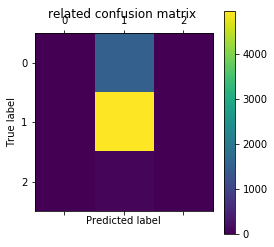

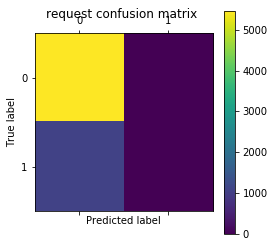

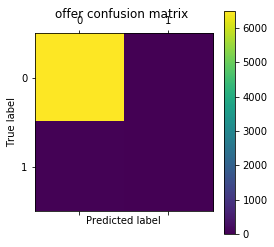

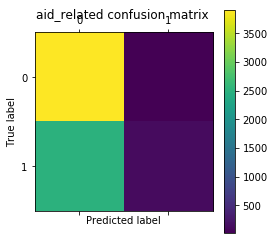

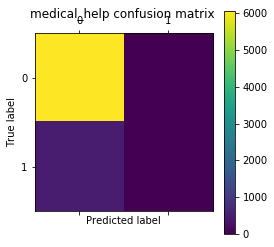

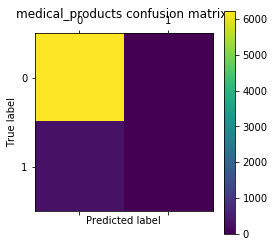

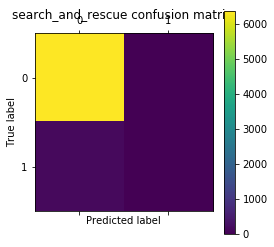

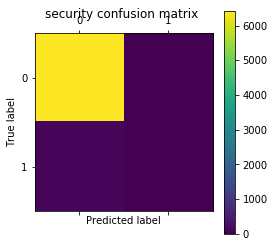

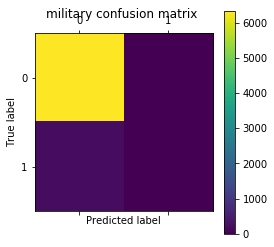

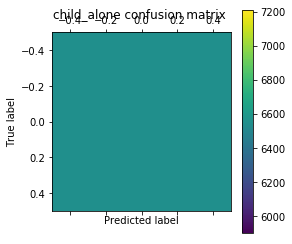

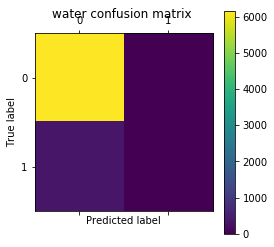

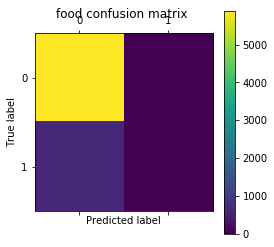

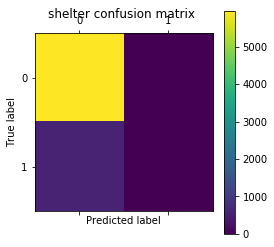

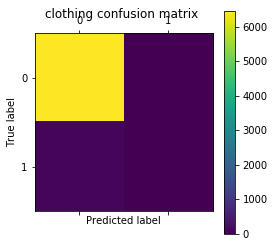

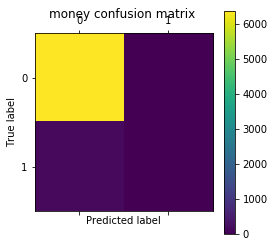

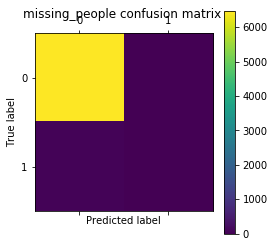

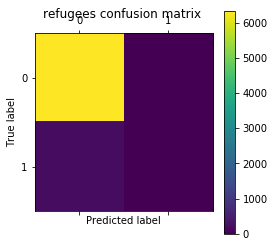

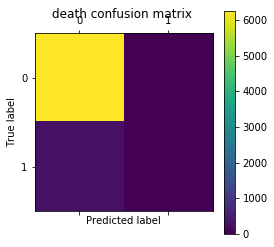

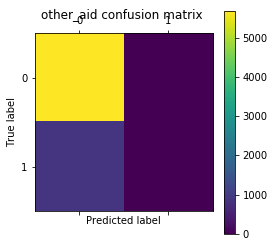

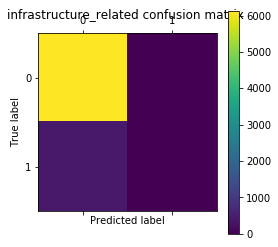

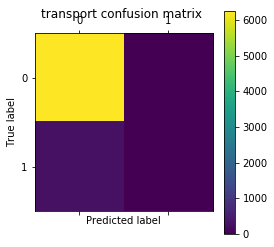

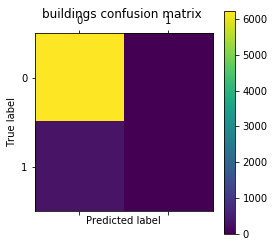

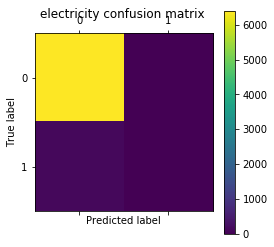

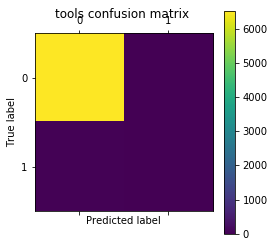

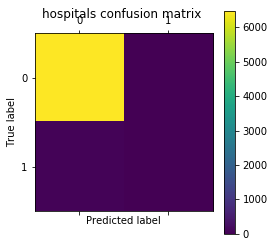

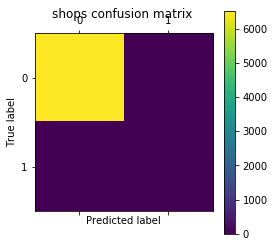

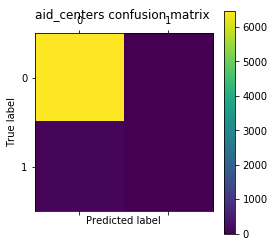

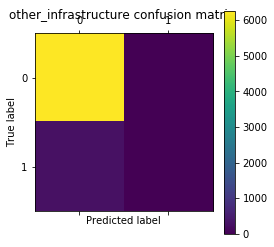

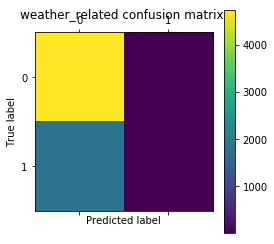

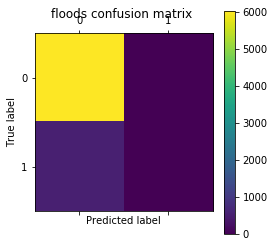

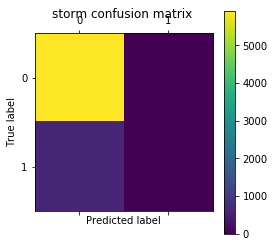

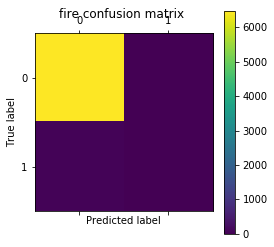

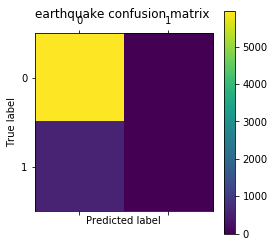

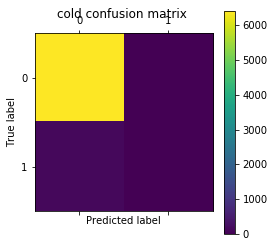

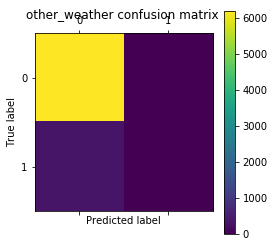

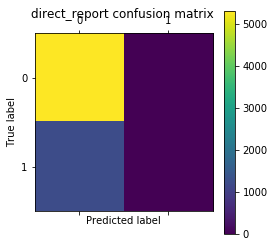

In [17]:
# confusion matrix usage to evaluate the quality of the output of a classifier on the data set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
for i in range(36):
    cm=confusion_matrix(y_test.iloc[:,i], y_pred[:,i])
    plt.matshow(cm)
    plt.title(y_test.columns[i]+" confusion matrix ")
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print('')

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [19]:
import pickle
  
pickle.dump(best_model, open('final_model.pkl', 'wb'))    

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.